# Deep Learning Project
 Michael Thoreau - Abhishek Hotkar


**Abstract**

 Access to high resolution satellite imagery has dramatically increased in recent years as several new constellations have entered service. High revisit frequencies as well as improved resolution has widened the use cases of satellite imagery to areas such as humanitarian relief and even Search and Rescue (SaR). We propose a novel remote sensing object detection dataset for deep learning assisted SaR. This dataset contains only very small objects that have been identified as potential targets in a live search and rescue scenario. We evaluate the application of popular object detection frameworks to this dataset as a baseline to inform further research. We also propose a novel object detection metric, specifically designed to be used in a deep learning assisted SaR setting. 

## Download the data

In [ ]:
!wget https://michaeltpublic.s3.amazonaws.com/paraglider_dataset.zip

In [ ]:
!unzip -q -o paraglider_dataset.zip 

## Install Dependencies and Setup Data Loaders

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.8)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.engine import DefaultTrainer

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

from detectron2.data.datasets import register_coco_instances



In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("dataset_train_1", {}, "/content/dataset/annotations/train.json", "/content/dataset/train")
register_coco_instances("dataset_val_1", {}, "/content/dataset/annotations/val.json", "/content/dataset/val")
register_coco_instances("dataset_test_1", {}, "/content/dataset/annotations/test.json", "/content/dataset/test")

In [ ]:
para_metadata = MetadataCatalog.get("dataset_train_1")
dataset_dicts = DatasetCatalog.get("dataset_train_1")
print(para_metadata)

[05/11 15:48:53 d2.data.datasets.coco]: Loaded 1808 images in COCO format from /content/dataset/annotations/train.json
Metadata(evaluator_type='coco', image_root='/content/dataset/train', json_file='/content/dataset/annotations/train.json', name='dataset_train_1', thing_classes=['target'], thing_dataset_id_to_contiguous_id={1: 0})


In [ ]:
para_metadata_val = MetadataCatalog.get("dataset_val_1")
dataset_dicts_val = DatasetCatalog.get("dataset_val_1")
print(para_metadata)

[05/11 16:21:49 d2.data.datasets.coco]: Loaded 490 images in COCO format from /content/dataset/annotations/val.json
Metadata(evaluator_type='coco', image_root='/content/dataset/train', json_file='/content/dataset/annotations/train.json', name='dataset_train_1', thing_classes=['target'], thing_dataset_id_to_contiguous_id={1: 0})


## Visualising data

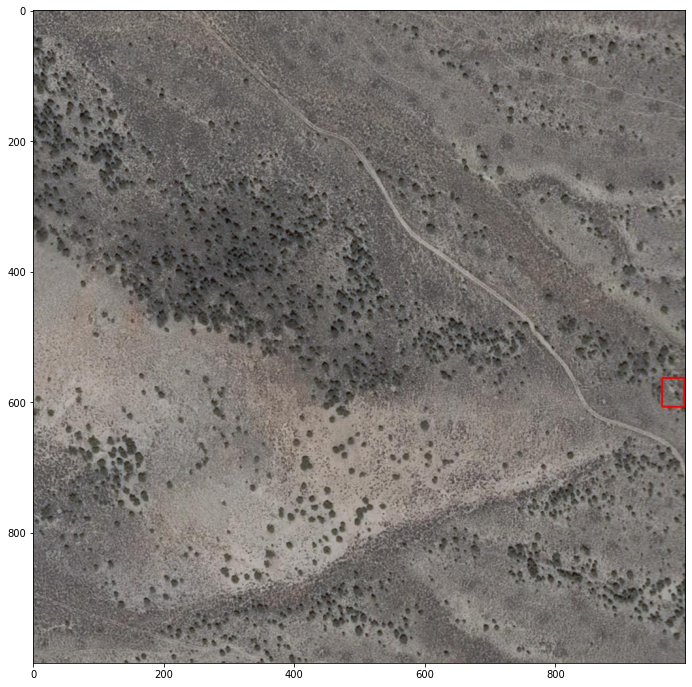

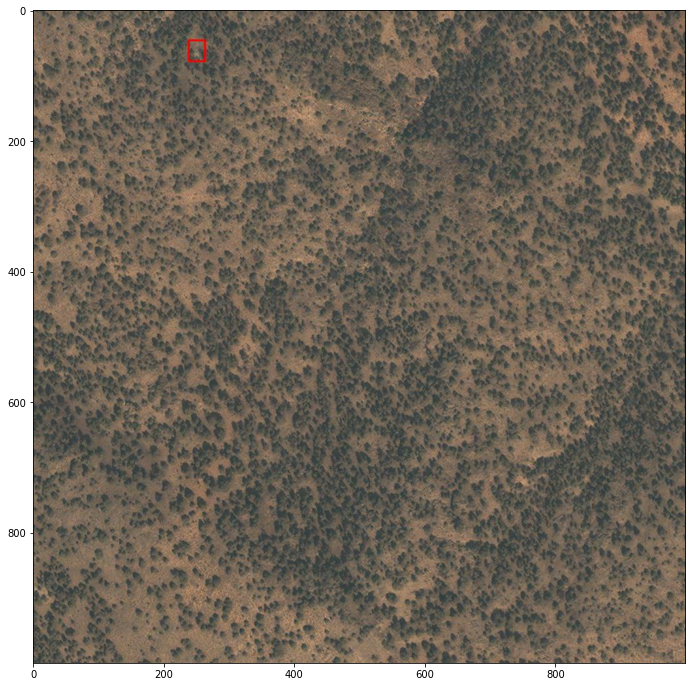

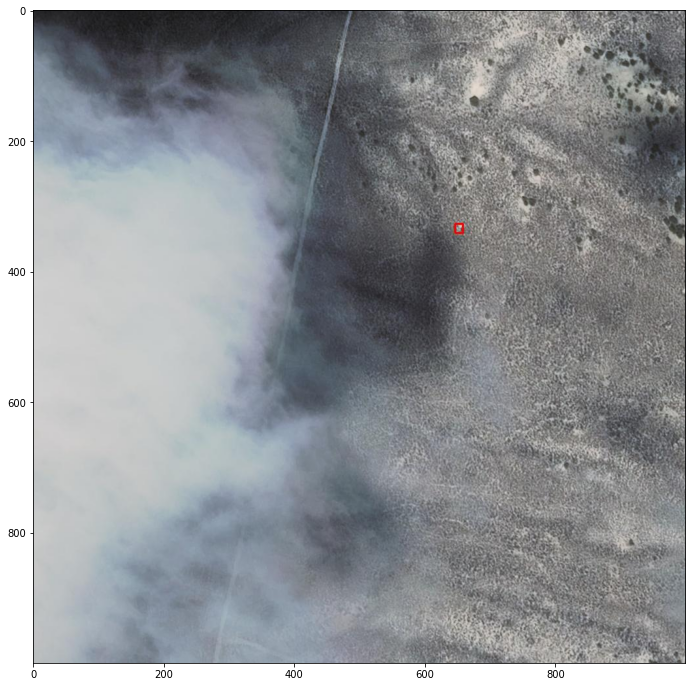

In [ ]:
# preview some of the data
import json
import random
import os
import cv2 as cv
%matplotlib inline
import matplotlib.pyplot as plt


with open("/content/dataset/annotations/train.json", 'r') as f:
  trainDict = json.load(f)

for img in random.sample(trainDict['images'], 3):
  filename = os.path.join("/content/dataset/previews/", img['file_name'])
  img = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2RGB)
  fig = plt.figure(figsize=(12,12))
  plt.imshow(img)

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=para_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

(500, 400, 3)


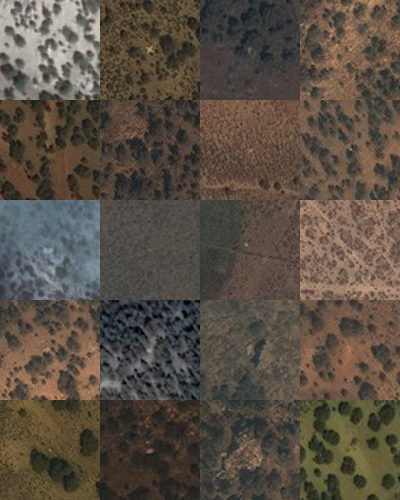

In [ ]:
# create mosaic of training samples
grid_shape = [4,5]
crop_size = [100,100]
mosaic = np.zeros((crop_size[1]*grid_shape[1], crop_size[0]*grid_shape[0], 3))
print(mosaic.shape)
img_list = []
while len(img_list) < grid_shape[0]*grid_shape[1]:
  for d in random.sample(dataset_dicts_val, 1):
    img = cv2.imread(d["file_name"])
    for annotation in random.sample(d['annotations'], 1):
      try:
        bbox = annotation['bbox']
        centre = [int(bbox[0] + bbox[2]/2), int(bbox[1] + bbox[3]/2)]
        crop_box = [int(centre[0]-crop_size[0]/2), int(centre[1]-crop_size[1]/2), 
                    int(centre[0]+crop_size[0]/2), int(centre[1]+crop_size[1]/2)] # x1, y1, x2, y2
        # cv2_imshow(img[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :])
        img_crop = img[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :]
        if img_crop.shape != (100,100,3):
          continue
        img_list.append(img[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :])
      except:
        pass

for j in range(grid_shape[1]):
  for i in range(grid_shape[0]):
    mosaic[j*crop_size[1]:(j+1)*crop_size[1], i*crop_size[0]:(i+1)*crop_size[0], :] = img_list[j*grid_shape[0]+i]

cv2.imwrite("mosaic.png", mosaic)
cv2_imshow(mosaic)

# Training

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging
import numpy as np

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if np.random.rand() > 0.1:
              continue
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            loss_batch = self._get_loss(inputs)
            
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        print("validation loss on 10% of val data: {}".format(mean_loss))
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD_LOSS,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

### ResNet 50 training

In [ ]:
# do configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("dataset_train_1",)
cfg.DATASETS.TEST = ("dataset_val_1",)
cfg.TEST.EVAL_PERIOD = 1000  # do a full coco evaluation every 500 iterations
cfg.TEST.EVAL_PERIOD_LOSS = 500 # calculate the validation loss every 100 iterations
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.2, 0.4]



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# faster_rcnn_R_50_DC5_3x.yaml

In [ ]:
# do configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml"))
cfg.OUTPUT_DIR = "faster_rcnn_R_50_DC5_3x"
cfg.DATASETS.TRAIN = ("dataset_train_1",)
cfg.DATASETS.TEST = ("dataset_val_1",)
cfg.TEST.EVAL_PERIOD = 1000  # do a full coco evaluation every 500 iterations
cfg.TEST.EVAL_PERIOD_LOSS = 500 # calculate the validation loss every 100 iterations
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.2, 0.4]



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


# faster_rcnn_R_50_C4_3x.yaml

In [ ]:
# do configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.OUTPUT_DIR = "faster_rcnn_R_50_C4_3x.yaml"
cfg.DATASETS.TRAIN = ("dataset_train_1",)
cfg.DATASETS.TEST = ("dataset_val_1",)
cfg.TEST.EVAL_PERIOD = 1000  # do a full coco evaluation every 500 iterations
cfg.TEST.EVAL_PERIOD_LOSS = 500 # calculate the validation loss every 100 iterations
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.2, 0.4]



os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

## Evaluation
The performance criteria for this application is less strict than for other applications, more false positives are acceptable. We will look at the number of predictions vs the recall.

In [ ]:
%matplotlib inline
para_metadata = MetadataCatalog.get("dataset_test_1")
dataset_dicts = DatasetCatalog.get("dataset_test_1")
import matplotlib.pyplot as plt
for d in random.sample(dataset_dicts, 10):
  img = cv2.imread(d["file_name"])

  # Inference should use the config with parameters that are used in training
  # cfg now already contains everything we've set previously. We changed it a little bit for inference:
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
  cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1
  predictor = DefaultPredictor(cfg)
  outputs = predictor(img)

  # convert image for display only
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  v = Visualizer(img[:, :, ::-1], para_metadata)
  v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  fig = plt.figure(figsize=(15,15))
  plt.imshow(v.get_image()[:, :, ::-1])


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from detectron2.structures import Boxes, BoxMode, pairwise_iou

Nsamples = 50

outputDirs = ["output", "faster_rcnn_R_50_C4_3x.yaml", "faster_rcnn_R_50_DC5_3x"]
modelNames = ["faster_rcnn_R_50_FPN_3x", "faster_rcnn_R_50_C4_3x", "faster_rcnn_R_50_DC5_3x"]



gt_boxes = [[],[],[]]
pred_boxes = [[],[],[]]
pred_scores = [[],[],[]]
for k, outputDir in enumerate(outputDirs):
  for j,d in enumerate(random.sample(dataset_dicts, Nsamples)):
    img = cv2.imread(d["file_name"])


    # Inference should use the config with parameters that are used in training
    # cfg now already contains everything we've set previously. We changed it a little bit for inference:
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01   # set a custom testing threshold
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1
    predictor = DefaultPredictor(cfg)
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")


    gtBoxArray = np.zeros((len(d['annotations']), 4))

    for i,annotation in enumerate(d['annotations']):
      gtBoxArray[i] = np.array(annotation['bbox'])

    # reformat ground truth boxes
    gtBoxArray = BoxMode.convert(gtBoxArray, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
    
    # prediction boxes - dont reformat
    # predBoxArray = BoxMode.convert(instances.pred_boxes.tensor.numpy(), BoxMode.XYXY_ABS, BoxMode.XYWH_ABS)
    predBoxArray = instances.pred_boxes.tensor.numpy()

    gt_boxes[k].append(gtBoxArray)
    pred_boxes[k].append(predBoxArray)
    pred_scores[k].append(instances.scores.numpy())

    print("testing: {}/{}".format(j,Nsamples))






In [ ]:
#IoU threshold
iou_threshold = 0.1

ground_truth_boxes = np.zeros((len(outputDirs)))
thresholds = np.linspace(0,1,100)
correct_boxes = np.zeros((len(outputDirs),thresholds.shape[0]))
prediction_boxes = np.zeros((len(outputDirs),thresholds.shape[0]))

for k, outputDir in enumerate(outputDirs):
  for j,t in enumerate(thresholds):
    ground_truth_boxes[k] = 0
    for i, (gtBoxArray, predBoxArray, scores) in enumerate(zip(gt_boxes[k], pred_boxes[k], pred_scores[k])):
      # print("{}------------------------------:".format(i))
      gtBoxObjs = Boxes(gtBoxArray)
      predBoxObjs = Boxes(predBoxArray)
      overlaps = np.array(pairwise_iou(predBoxObjs, gtBoxObjs))
      # print(overlaps, scores)
      ground_truth_boxes[k] += gtBoxArray.shape[0]
      for score in scores:
        if score >= t:
          prediction_boxes[k][j] += 1

      # check for a correct prediction for each gt box
      for gt in range(overlaps.shape[1]):
        for predOverlap, score in zip(overlaps[:,gt], scores):
          # print(predOverlap, score)
          if predOverlap > iou_threshold and score > t:
            correct_boxes[k][j] += + 1

print(ground_truth_boxes, prediction_boxes, correct_boxes)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


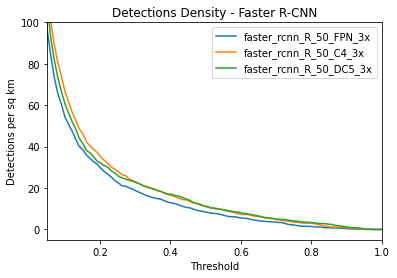

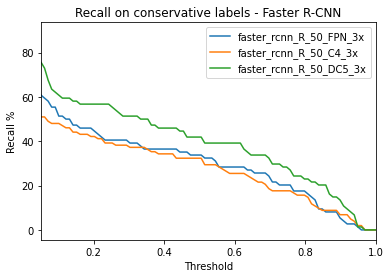

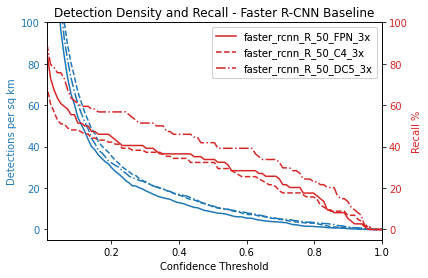

In [ ]:
modelNames = ["faster_rcnn_R_50_FPN_3x", "faster_rcnn_R_50_C4_3x", "faster_rcnn_R_50_DC5_3x"]


fig = plt.figure()
for k, outputDir in enumerate(modelNames):
  plt.plot(thresholds, prediction_boxes[k]/(Nsamples*0.25))  

plt.legend(modelNames)
plt.xlim([0.05, 1.0])
plt.ylim([-5, 100])
plt.title("Detections Density - Faster R-CNN")
plt.xlabel("Threshold")
plt.ylabel("Detections per sq km")

fig = plt.figure()
for k, outputDir in enumerate(modelNames):
  plt.plot(thresholds, 100*correct_boxes[k]/ground_truth_boxes[k])

plt.legend(modelNames)
plt.xlim([0.05, 1.0])
plt.title("Recall on conservative labels - Faster R-CNN")
plt.ylabel("Recall %")
plt.xlabel("Threshold")


styles = ['-', '--', '-.']

fig, ax1 = plt.subplots()
plt.title("Detection Density and Recall - Faster R-CNN Baseline")
color = 'tab:blue'
ax1.set_xlabel('Confidence Threshold')
ax1.set_ylabel('Detections per sq km', color=color)
for k, outputDir in enumerate(modelNames):
  ax1.plot(thresholds, prediction_boxes[k]/(Nsamples*0.25), color=color, linestyle=styles[k])
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlim([0.01, 1.0])
ax1.set_ylim([-5, 100])
ax1.legend(modelNames)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Recall %', color=color)  # we already handled the x-label with ax1

for k, outputDir in enumerate(modelNames):
  ax2.plot(thresholds, 100*correct_boxes[k]/ground_truth_boxes[k], color=color, linestyle=styles[k])

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xlim([0.01, 1.0])
ax2.set_ylim([-5, 100])
ax2.legend(modelNames)
plt.savefig("density_and_recall.png", dpi=300)
plt.savefig("density_and_recall.eps")
plt.show()

**Compute AR-d20**

In [ ]:
ARd20 = np.zeros((len(modelNames)))

for l, outputDir in enumerate(modelNames):
  gts = ground_truth_boxes[l]
  correct = correct_boxes[l]
  densities = np.array(prediction_boxes[l])/(Nsamples*0.25)
  

  # find the lowest threshold that corresponds to a density lower than k
  for k in np.linspace(0,20, 21):
    r = correct[densities < k]
    if len(r) > 1:
      # ARd20[l] += t[0]/20
      r = 100*r[0]/gts
      print(k, r)
      ARd20[l] += r/20



for model, score in zip(modelNames, ARd20):
  print("Model:      {:30s}   ARd-20: {:.2f}".format(model, score))

    


1.0 9.45945945945946
2.0 20.27027027027027
3.0 20.27027027027027
4.0 25.675675675675677
5.0 28.37837837837838
6.0 28.37837837837838
7.0 28.37837837837838
8.0 32.432432432432435
9.0 33.78378378378378
10.0 35.13513513513514
11.0 35.13513513513514
12.0 36.486486486486484
13.0 36.486486486486484
14.0 36.486486486486484
15.0 36.486486486486484
16.0 36.486486486486484
17.0 37.83783783783784
18.0 39.189189189189186
19.0 39.189189189189186
20.0 40.54054054054054
1.0 6.862745098039215
2.0 9.803921568627452
3.0 14.705882352941176
4.0 17.647058823529413
5.0 18.627450980392158
6.0 21.568627450980394
7.0 25.49019607843137
8.0 25.49019607843137
9.0 27.45098039215686
10.0 29.41176470588235
11.0 32.35294117647059
12.0 32.35294117647059
13.0 32.35294117647059
14.0 32.35294117647059
15.0 32.35294117647059
16.0 34.31372549019608
17.0 34.31372549019608
18.0 34.31372549019608
19.0 35.294117647058826
20.0 36.27450980392157
1.0 10.81081081081081
2.0 16.216216216216218
3.0 21.62162162162162
4.0 24.32432432432